In [2]:
#Data analysis libraries
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import datasets
from geopy.geocoders import Nominatim
geolocator = Nominatim()

#Visualization libraries
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython.display import IFrame

#Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Singapore HDB Resale Price Prediction Based on Governmental Data
<hr>
Predicting housing prices is an extensive researched topic in economics and data science. Previously conducted studies by [4,5,6,8] showed that a neural network is better performing to predict future value than a multiple regression model. This is especially the case for a "true" open market [4]. This is contradicted by [7], who argue that results from neural networks vary widely, while traditional regression models are more consistent. Besides predicting prices based on features, novel prediction models have been developed. For example, a price prediction model that looks at the $#$ of searches on Google [9]. Although the researchers found that searches and housing prices are correlated, it is difficult to predict the housing price of a specific building and its characteristics.

Studies conducted often work with an extensive list of variables, including features of the house, but also from the environment and the amenities. For example, [10] use variables such as size (in square meters) and age, but also the presence of a garage or swimming pool. 

### Characteristics of the HDB Property Market
In Singapore, a distinction can be made between two types of properties: a private residential market and a market that is managed by the Housing and Development Board (HDB), which is part of the Ministry of National Development [2]. The flats developed in the HDB market are heavily subsidized by the Singaporean government, and are affordable alternatives for Singaporean residents.

The market for HDB properties differs from the private residential market in several ways. Firstly, the properties are leased to the residents. This lease period is typically 99 years. After the period, the property ownership rights are again in the hands of HDB. Thus, the owner of an HDB apartment is simply leasing it for an extensive amount of time. This differs from renting, since in that case the tenant needs to pay monthly based on actual market conditions [3]. Besides the lease, the owner can be eligible to rent out or sell the flat during the lease period. This created a new market, bla bla...

A previous study conducted in the private residential market [11] shows variables being used in their predictive model. This includes dummy variables for a total of 15 facilities, ranging from swimming pool to security and gyms. The study also took into account unit characteristics, such as size, age and floor level. HDB flats do not have additional facilities, but have similar unit characteristics. The model also takes into account the distance to strategic positions, such as MRT stations and schools.

### Singaporean Townships and Areas
The Housing and Development Board makes a distinction between a total of 23 townships, located in 5 different areas [12]. The areas define their location within the city-state, whereas the township concatenates a community with its own council. The map below highlights the areas and townships. The areas are respectively: north (red), nort-east (yellow), east (blue), central (brown) and west (green). The pins indicate the townships included.

In [3]:
IFrame('https://www.google.com/maps/d/u/0/embed?mid=1Gv4-kVYanSXMj8Q2ldJKJkzTilOlEZxL', width=800, height=300)

## Research Objective
<hr>
Since the market is monitored by the Singaporean government, it can be considered as not truly open. Therefore, based on previous research, a regression model might be sufficient. This research aims to validate if a regression model is sufficient for predicting housing prices in the HDB resale market. The HDB resale data from the Singaporean government, spanning from 1990 until January 2018, is used to develop the model.

## 1 Data Acquisition
<hr>
The data for this report is acquired from the Singapore government website [1]. Data are collected from the period 1990 until January 2018. The data is provided in four seperate files, which will be merged into Python. The third file (> 20 MB) was seperated into periods of 2006-2012 and 2012-2014. This was necessary to make use of the Github repository.

In [4]:
#Load datasets
data1 = pd.read_csv('sg-resale-flat-prices-1990-1999.csv', sep =',')
print('Number of training data =', data1.shape)

data2 = pd.read_csv('sg-resale-flat-prices-2000-2005.csv', sep =',')
print('Number of training data =', data2.shape)

data3 = pd.read_csv('sg-resale-flat-prices-2006-2012.csv', sep =',')
print('Number of training data =', data3.shape)

data4 = pd.read_csv('sg-resale-flat-prices-2012-2014.csv', sep =',')
print('Number of training data =', data4.shape)

data5 = pd.read_csv('sg-resale-flat-prices-2014-2018.csv', sep =',')
print('Number of training data =', data5.shape)

Number of training data = (288144, 10)
Number of training data = (197175, 10)
Number of training data = (172476, 10)
Number of training data = (52203, 10)
Number of training data = (58631, 11)


Following the shape of the data, there is a noticable difference from the last dataset. To discover which variable has been added to the dataset, we recall the first two features from both the first and the last dataset.

In [5]:
#Show two features of data set 1
data1.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000


In [6]:
#Show two features of data set 5
data5.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0


By comparing the two data sets, we can see that the extra feature is the remaining lease year of the HBD housing. In Singapore, the lease of the HBD housing starts with 99 years. In the 99 years, the appartment can be resold to someone else, but this does not mean that 99 years will be refreshed. The number of years the previous owner has lived in the appartment will be substracted instead. After the remaining lease year, the current owner will have to move [source]. We believe this is an important feature to consider in the predictive model. Therefore, we will recalculate the row for the other data sets as well during the preprocessing stage. 

In [7]:
#Concatenate datasets
sets = [data1, data2, data3, data4, data5]
data = pd.concat(sets)
print('Number of training data =', data.shape[0])
print('Number of features =', data.shape[1])

Number of training data = 768629
Number of features = 11


## 2 Exploration of the Dataset
<hr>
To start exploring the data, the dataset are loaded. From the dataset, we can conclude the data contain 768.629 datapoints and 11 features. 

### 2.1 Data description and information

In [8]:
#load dataset
n = data.shape[0]
print('Number of training data =',n)
print(data.shape)

Number of training data = 768629
(768629, 11)


We use data.describe() to have a look at some key metrics of the data set.

In [9]:
print(data.describe())

       floor_area_sqm  lease_commence_date  remaining_lease  resale_price
count   768629.000000        768629.000000     58631.000000  7.686290e+05
mean        95.455564          1986.563476        74.013832  2.823196e+05
std         26.210450             8.851260        11.255427  1.424499e+05
min         28.000000          1966.000000        47.000000  5.000000e+03
25%         72.000000          1980.000000        66.000000  1.750000e+05
50%         93.000000          1985.000000        72.000000  2.650000e+05
75%        114.000000          1993.000000        83.000000  3.700000e+05
max        307.000000          2015.000000        97.000000  1.180000e+06


We can conclude:
- All appartments vary between the size of 28 and 307 sqm. The mean is 95.46 sqm.
- The oldest lease start date is 1966 and the oldest one is 2015. Thus no appartment in this list has a lease that expires before 2065. The mean lease start date is 1987. 
- Resale prices vary between 5000 SGD and 1.18 million SGD. It has to be verified if a price of 5000SGD is possible or is due to faulty data. The median price lies at 282k SGD.
- Overall, at a first glance the dataset seems to be clean and free of faulty datapoints. <br>

In the subsequent section, the data types are retrieved from the dataset.

In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768629 entries, 0 to 58630
Data columns (total 11 columns):
block                  768629 non-null object
flat_model             768629 non-null object
flat_type              768629 non-null object
floor_area_sqm         768629 non-null float64
lease_commence_date    768629 non-null int64
month                  768629 non-null object
remaining_lease        58631 non-null float64
resale_price           768629 non-null float64
storey_range           768629 non-null object
street_name            768629 non-null object
town                   768629 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 70.4+ MB
None


We can see that the data list is complete, as all features have 768.629 values. <br>

After loading the data, the data are explored. Features are checked to see whether cleaning and preprocessing of the data is needed.

## 2.2 Univariate plots

#### 2.2.1 Time of Sale

#### 2.2.2 Town

In [11]:
#town count
towns = np.unique(data['town'])
sns.countplot(x="town", data=data , order=towns)
plt.ylabel('Resales', fontsize=12)
plt.xlabel('Township', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Resale Frequency per Township", fontsize=12)
plt.show()
print("Town Count \n" +str(data['town'].value_counts()))

NameError: name 'sns' is not defined

In [ ]:
town_array = np.unique(data['town'])
n = data['town'].nunique()
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['town'] == town_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['town'] == town_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(town_array,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Town', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each Town", fontsize=12)
plt.show()

Observations:
- Besides Bukit Timah and Lim Chu Kang, all towns have more than 5000 sales occurrences.
- TAMPINES is the most present town, with 69236 sales.
- Lim Chu Kang is a clear outlier in terms of price/sqm. This is probably correlated to the low number of only 64 sales registered in that area.
- The most expensive town is Punggol.

#### 2.2.3 Flat_type

In [ ]:
#flat_type count
flat_type = np.unique(data['flat_type'])
sns.countplot(x="flat_type", data=data , order = flat_type)
plt.ylabel('Count', fontsize=12)
plt.xlabel('flat_type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of flat_type Count", fontsize=12)
plt.show()
print("Flat Type Count \n" +str(data['flat_type'].value_counts()))

ValueError: Invalid RGBA argument: 0.73774821351816544

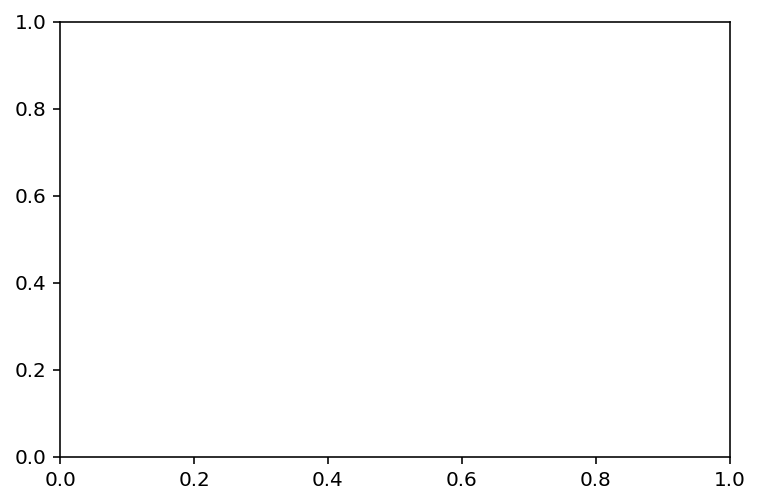

In [13]:
x = data['month']
y = data['resale_price']

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

In [ ]:
flat_type_array = np.unique(data['flat_type'])
n = data['flat_type'].nunique()
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['flat_type'] == flat_type_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['flat_type'] == flat_type_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(flat_type_array,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Flat_type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each flat_type", fontsize=12)
plt.show()

Observations:
- 1 Room, 2 Room, and Multi-Generations are clearly fewer than the remaining flat types.
- The most common flat type is 4 rooms.
- Prices per sqm, surprisingly, seem to up with flat size.

#### 2.2.4 Flat_model

In [ ]:
#flat_model count
flat_model = np.unique(data['flat_model'])
sns.countplot(x="flat_model", data=data , order = flat_model)
plt.ylabel('Count', fontsize=12)
plt.xlabel('flat_model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of flat_model Count", fontsize=12)
plt.show()
print("Flat Model Count \n" +str(data['flat_model'].value_counts()))

In [ ]:
flat_model_array = np.unique(data['flat_model'])
n = data['flat_model'].nunique()
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['flat_model'] == flat_model_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['flat_model'] == flat_model_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(flat_model_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('flat_model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each flat_model", fontsize=12)
plt.show()

Obersvations:
- Concerning flat_models, there are lot of flat_models that exist less than a 1000 times.
- The most common ones are 'Model A' and 'Improved'.
- Prices/sqm vary widely, which is probably due to some sample sizes being very small.

#### 2.2.5 Lease commencement year

In [ ]:
lease_year = np.unique(data['lease_commence_date'])
year_count_l = data['lease_commence_date'].value_counts()
sns.barplot(year_count_l.index, year_count_l.values, order=lease_year)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_year Count", fontsize=12)
plt.show()

count_lease_year = data['lease_commence_date'].nunique()
print("Total Sales Year Count:", count_lease_year)
lease_year_count = data['lease_commence_date'].value_counts()
print("Sales Year Count \n" +str(lease_year_count))

In [ ]:
lease_commence_date_array = np.unique(data['lease_commence_date'])
n = data['lease_commence_date'].nunique()
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['lease_commence_date'] == lease_commence_date_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['lease_commence_date'] == lease_commence_date_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(lease_commence_date_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('lease_commence_date', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each lease_commence_date", fontsize=12)
plt.show()

ValueError: Invalid RGBA argument: 0.97090482023077362

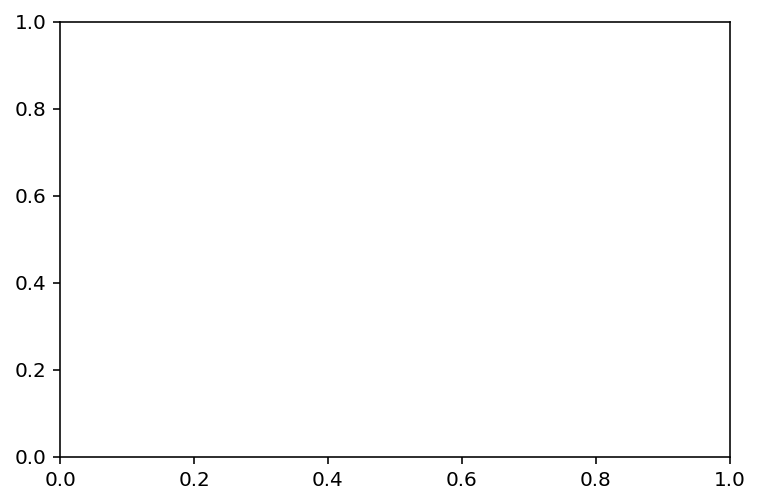

In [15]:
N = 50
x = data['month']
y = data['resale_price']
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Observations:
- The years 1984-1990 have the most commencement dates. Before there is a ongoing increase and after an ongoing decrease.
- Prices/sqm remain relatively flat for commencement dates from 1966 to 2000 and increase from 2000 to 2012.

#### 2.2.6 Sales

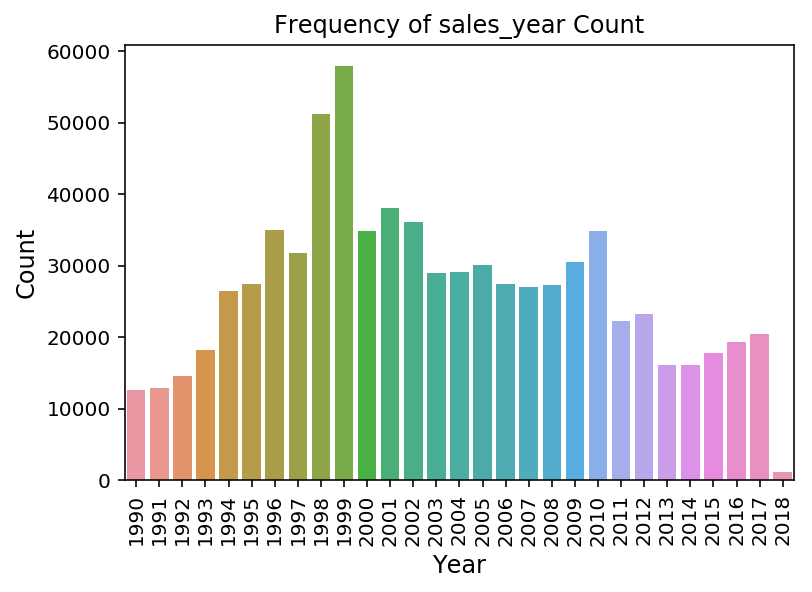

Sales Year Count 
1999    57906
1998    51201
2001    38055
2002    36098
1996    35014
2000    34862
2010    34854
1997    31815
2009    30482
2005    30045
2004    29112
2003    29003
2006    27427
1995    27368
2008    27262
2007    26982
1994    26474
2012    23198
2011    22281
2017    20390
2016    19373
1993    18193
2015    17780
2013    16097
2014    16096
1992    14607
1991    12954
1990    12612
2018     1088
Name: month, dtype: int64


In [20]:
#yearly sales trend
sales_year = np.unique(pd.DatetimeIndex(data['month']).year.values)
year_count=pd.DatetimeIndex(data['month']).year.value_counts()
sns.barplot(year_count.index, year_count.values, order=sales_year)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_year Count", fontsize=12)
plt.show()
print("Sales Year Count \n" +str((pd.DatetimeIndex(data['month']).year).value_counts()))

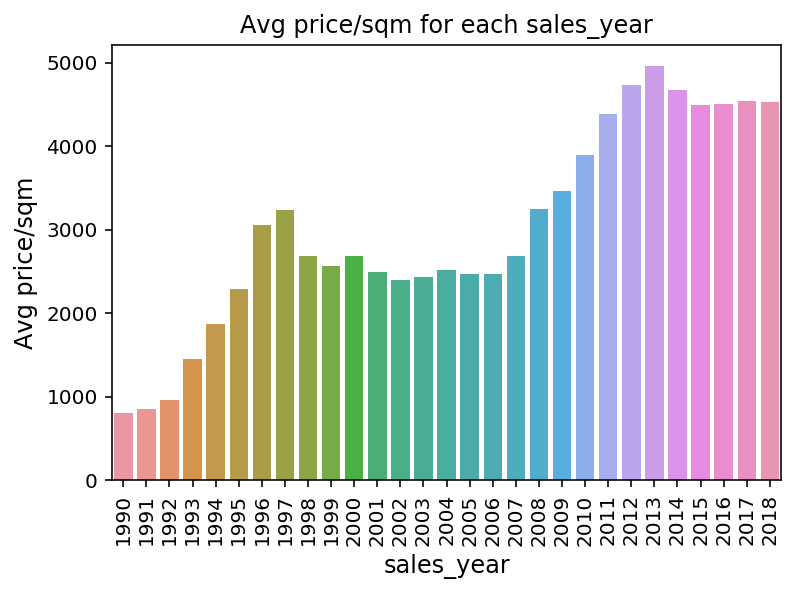

In [21]:
sales_year_array = np.unique(pd.DatetimeIndex(data['month']).year.values)
n = len(sales_year_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][pd.DatetimeIndex(data['month']).year.values == sales_year_array[i]].sum()
        sqmm = data['floor_area_sqm'][pd.DatetimeIndex(data['month']).year.values == sales_year_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(sales_year_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('sales_year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each sales_year", fontsize=12)
plt.show()

Observations:
- Counts of Sales per year increase from 1990 to 1999 and decrease thereafter.
- As expected, in general, prices per sqm increase over time.
- However there was a dip after 1997 and after 2013.

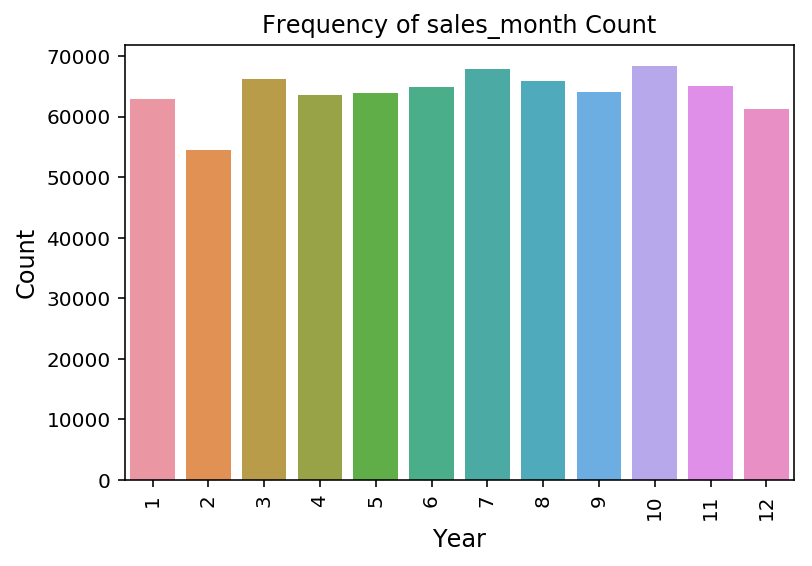

Sales Month Count 
10    68395
7     67944
3     66163
8     65883
11    65118
6     64940
9     64071
5     63941
4     63497
1     62865
12    61241
2     54571
Name: month, dtype: int64


In [ ]:
#monthly sales trend
sales_month = np.unique(pd.DatetimeIndex(data['month']).month.values)
year_count=pd.DatetimeIndex(data['month']).month.value_counts()

sns.barplot(year_count.index, year_count.values, order=sales_month)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_month Count", fontsize=12)
plt.show()
print("Sales Month Count \n" +str((pd.DatetimeIndex(data['month']).month).value_counts()))

In [ ]:
month_year_array = np.unique(pd.DatetimeIndex(data['month']).month.values)
n = len(month_year_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][pd.DatetimeIndex(data['month']).month.values == month_year_array[i]].sum()
        sqmm = data['floor_area_sqm'][pd.DatetimeIndex(data['month']).month.values == month_year_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(month_year_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('sales_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each sales_month", fontsize=12)
plt.show()

Observations:
- It seems like the last and first month of a year have slightly lower prices than the middle months.

#### 2.2.7 SQM

In [ ]:
# SQM distribution
plt.hist(data['floor_area_sqm'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor_area_sqm', fontsize=12)
plt.xticks(rotation='vertical')
plt.xlim(0,200)
plt.title("Distribution of SQM", fontsize=12)
plt.show()

In [ ]:
sqm_array = np.unique(data['floor_area_sqm'])
n = len(sqm_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['floor_area_sqm'] == sqm_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['floor_area_sqm'] == sqm_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

plt.plot(sqm_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('floor_area_sqm', fontsize=12)
plt.xticks(rotation='vertical')
plt.xlim(0,300)
plt.title("Avg price/sqm for each floor_area_sqm", fontsize=12)
plt.show()

Observations:
- We can see that the largest chunk of the HBDs are between 25 and 200 sqm.
- There are strong variations of counts between the different bins.
- Prices per sqm seem to be highest in the mid-range of SQM.

#### 2.2.8 Storey

In [ ]:
sns.countplot(x="storey_range", data=data, order=storey_array)
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of storey_range Count", fontsize=12)
plt.show()

In [ ]:
storey_array = np.unique(data['storey_range'])
n = len(storey_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['storey_range'] == storey_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['storey_range'] == storey_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(storey_array,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Storey', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each storey", fontsize=12)
plt.show()

Observations:
- There is a clear upwards trend in prices for higher stories.
- There are few storey ranges that spike in price.
- Those ranges also tend to have really low frequency.
- These ranges also tend to be included in other ranges.
- It is possible that e.g. in recent years, which have higher prices, the storey format changed; which would explain higher avg. prices per sqm.

#### 2.2.9 Output (price)

In [ ]:
# Price distribution
plt.hist(data['resale_price'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('resale_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of resale_price", fontsize=12)
plt.show()

plt.hist(data['resale_price'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('resale_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.ylim(0,5000)
plt.xlim(0,20000)
plt.title("Distribution of resale_price", fontsize=12)
plt.show()

Observations:
- Practically no prices per flat go above 1,000,000 SGD.
- The majority of prices are betwenn 150,000 and 400,000 SGD.
- There seems to be a number of flats (400+) that were sold for less than 10,000 SGD.

## 3 Cleaning and Preprocessing the Dataset
<hr>
After exploring the dataset, we came across the following points for preprocessing the data: 
- The feature month consists of sales year and month, e.g. 1990-01. To include the variable in the model, this variable will be seperated to a variable called sales year and a variable called month. 
- However, a linear regression will not be able to read the years, since it can see it as another numerical value. Therefore, the remaining lease year is calculated. Once the sales year variable is created, the remaining lease year can be computed by using the following formula: $remaining lease year = 99 - (sales year - lease commence date)$.
- Furthermore, there are rows containing characters. These rows (town, flat type, flat model and storey range) are transformed into dummy variables to clarify their levels, with other words, to quantify the qualitative data. <br>

### 3.1 Feature Engineering
In this part, we will explore new features that we can add to make our data more valuable.

### 3.2 Variables

The variables considered in the research will be: <br>
$x_1$ Remaining lease year <br>
$x_2$ Floor area squared meters <br>
$D_3$ Town and/or Area <br>
$D_4$ Flat type <br>
$D_5$ Flat model <br>
$D_6$ Storey range <br>
$x_7$ Month <br>
$Y$ Resale price <br>

In [23]:
location = geolocator.geocode(data['street_name'])
print(location.latitude, location.longitude)


GeocoderTimedOut: Service timed out

## 4 Data Analysis
<hr>
This part of the report will show algorithms that have been applied to predict the housing prices. We have focused on regressions with different features. <br>

### 4.1 Linear Regression
Predictive model with linear regression

### 4.2 Error Analysis 
To perform the error analysis, the accuracy are considered to 

### 4.3 Cross Validation
To check whether the data is overfitting 

https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

## 5 Results
<hr>
Based on the analysis, the following results are derived:

## 6 Conclusion
<hr>
From this research, we can conclude

## Citations
<hr>
[1] Retrieved from the Internet: <br />
[2] Jiang, L., Phillips, P., & Yu, J. (2014). A new hedonic regression for real estate prices applied to the Singapore residential market. <br />
[3] Retrieved from the Internet: https://www.gov.sg/factually/content/do-hdb-flat-buyers-own-their-flat <br />
[4] Tay D. P. H. and D. K. H. Ho, 1991, “Artificial Intelligence and The Mass Appraisal of
Residential Apartments”, Journal of Property Valuation & Investment, 10(2): 525 – 539. <br />
[5] Do A. Q. and G. Grudnitski, 1992, “A Neural Network Approach to Residential Property
Appraisal”, The Real Estate Appraiser, 58(3): 38 – 45. <br />
[6] McCluskey W., 1996, “Predictive Accuracy of Machine Learning Models for The Mass
Appraisal of Residential Property”, New Zealand Valuers’ Journal, July: 41 – 47. <br />
[7] Worzala E., M. Lenk and A.Silva, 1995, “An Exploration of Neural Networks and Its
Application to Real Estate Valuation”, The Journal of Real Estate Research, 10(2): 185 –
201 <br />
[8] Limsombunchai, V. (2004, June). House price prediction: hedonic price model vs. artificial neural network. In New Zealand Agricultural and Resource Economics Society Conference (pp. 25-26). <br />
[9] Wu, L., & Brynjolfsson, E. (2015). The future of prediction: How Google searches foreshadow housing prices and sales. In Economic analysis of the digital economy (pp. 89-118). University of Chicago Press.<br />
[10] Basu, S., & Thibodeau, T. G. (1998). Analysis of spatial autocorrelation in house prices. The Journal of Real Estate Finance and Economics, 17(1), 61-85. <br />
[11] Tu, Y., Sun, H., & Yu, S. M. (2007). Spatial autocorrelations and urban housing market segmentation. The Journal of Real Estate Finance and Economics, 34(3), 385-406.<br />
[12] From the Internet: http://www.hdb.gov.sg/cs/infoweb/about-us/history/hdb-towns-your-home <br />